In [1]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.graphics.tsaplots import plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Disable JIT Compilation in TensorFlow
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=0'

# Load the dataset
data = pd.read_csv('TSLA.csv')
data.head()


2024-08-23 18:43:52.534819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 18:43:52.684500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 18:43:52.686581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 18:43:52.891331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 18:43:54.489724: W tensorflow/compiler/tf

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


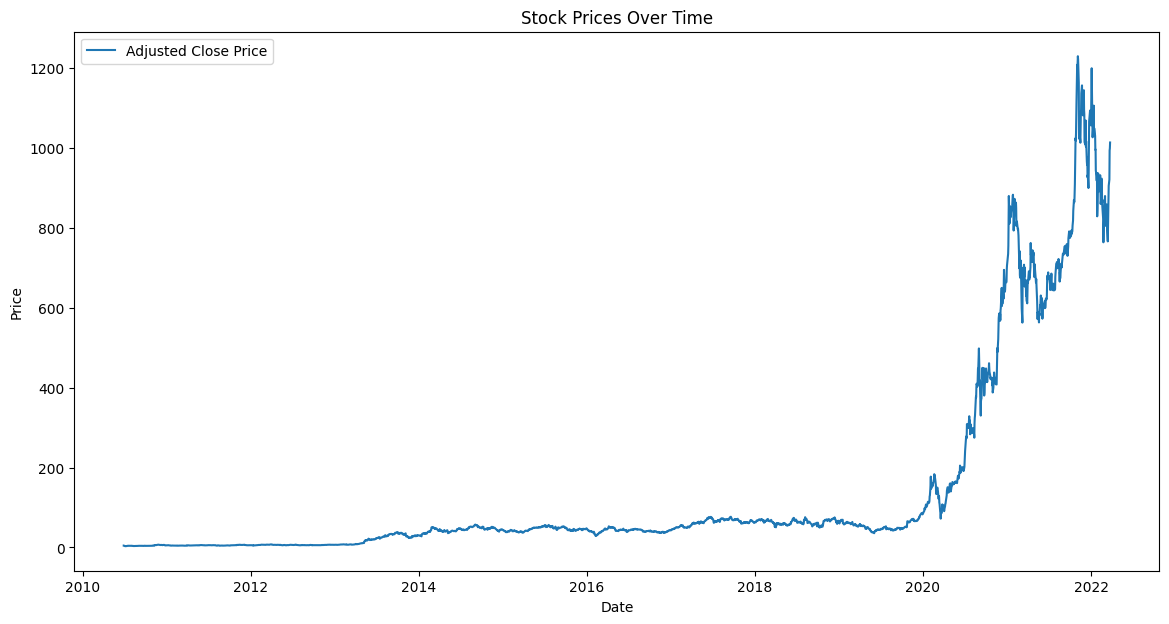

In [2]:

# Check for missing values and drop them
data = data.dropna()

# Prepare the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Initial Data Exploration: Plotting Stock Prices
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


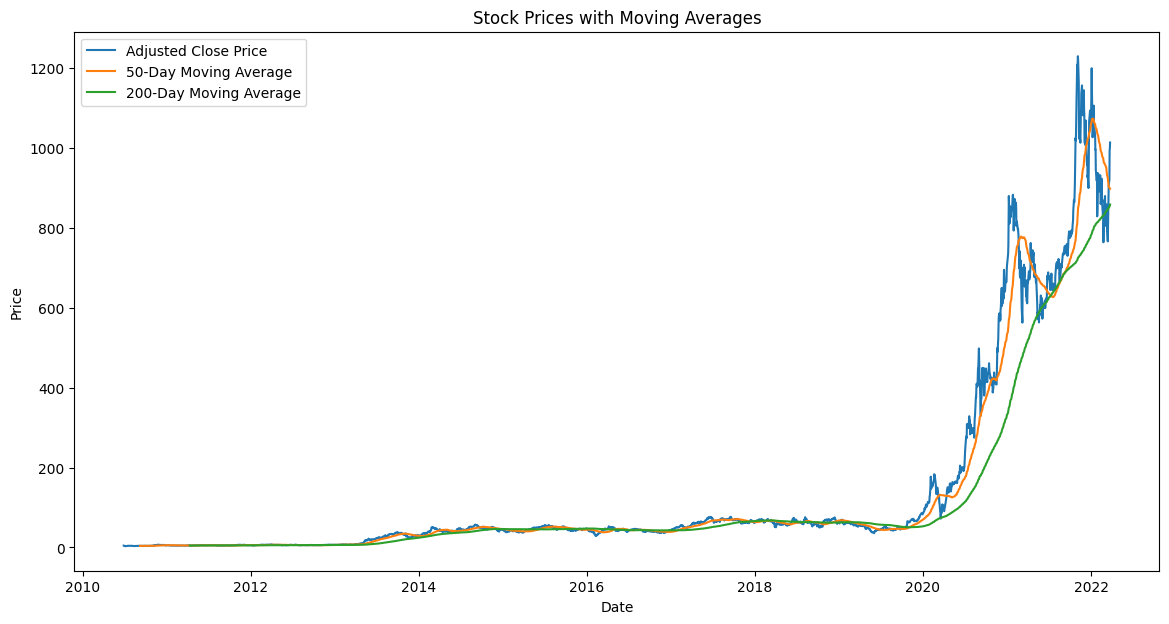

In [3]:

# Moving Average Plot
data['MA50'] = data['Adj Close'].rolling(window=50).mean()
data['MA200'] = data['Adj Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price')
plt.plot(data.index, data['MA50'], label='50-Day Moving Average')
plt.plot(data.index, data['MA200'], label='200-Day Moving Average')
plt.title('Stock Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


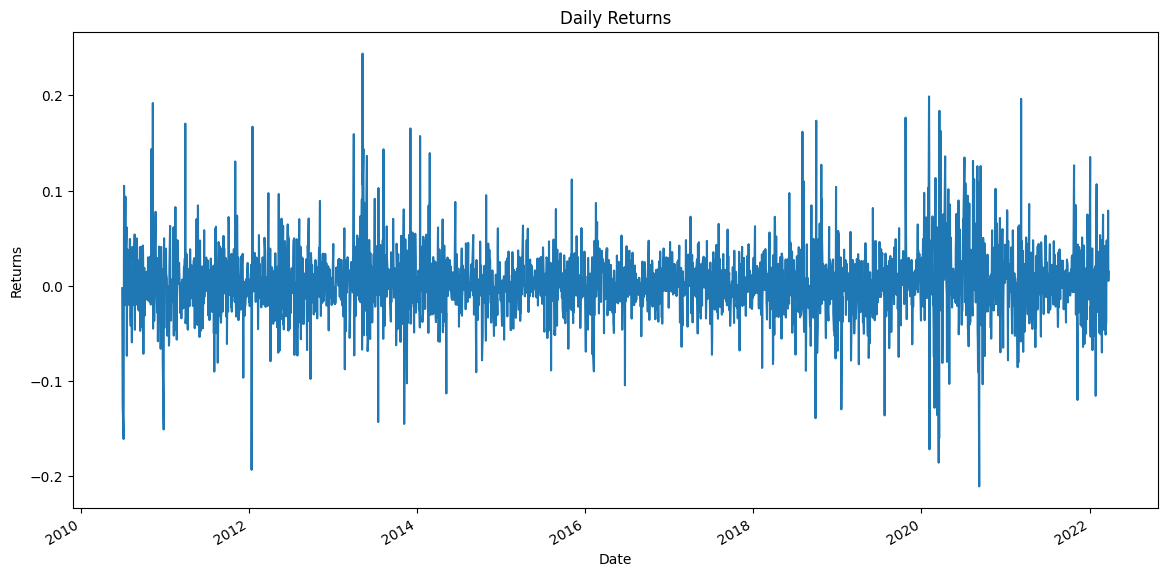

In [4]:

# Rolling Statistics: Daily Returns
data['Returns'] = data['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
data['Returns'].plot()
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()


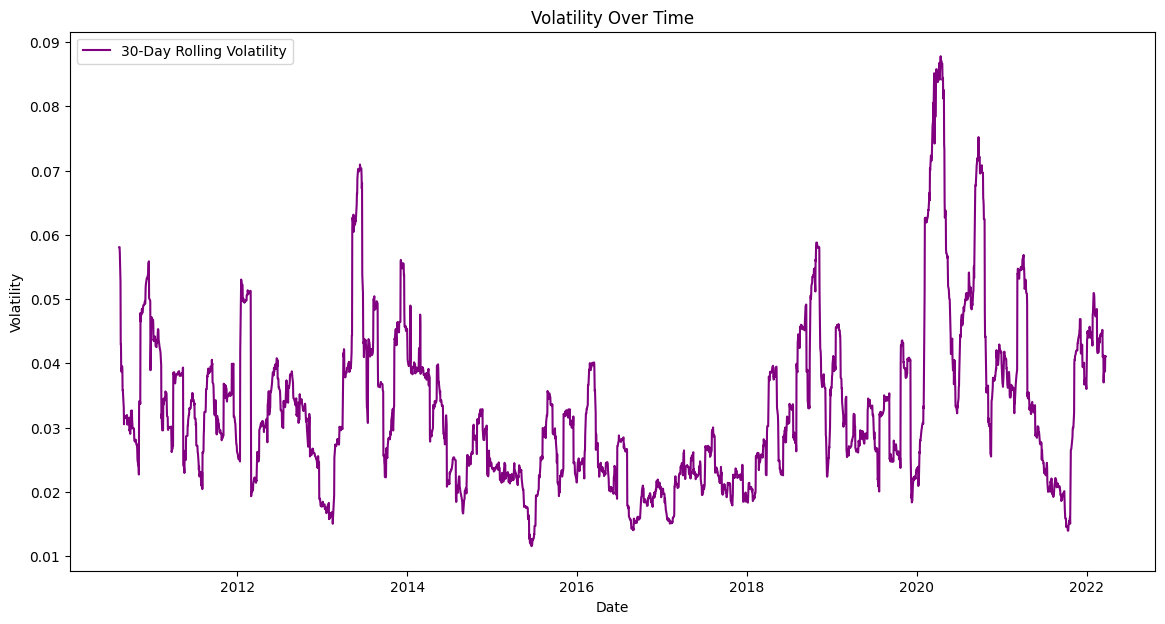

In [5]:

# Additional Plot: Volatility Over Time
data['Volatility'] = data['Returns'].rolling(window=30).std()
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Volatility'], label='30-Day Rolling Volatility', color='purple')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


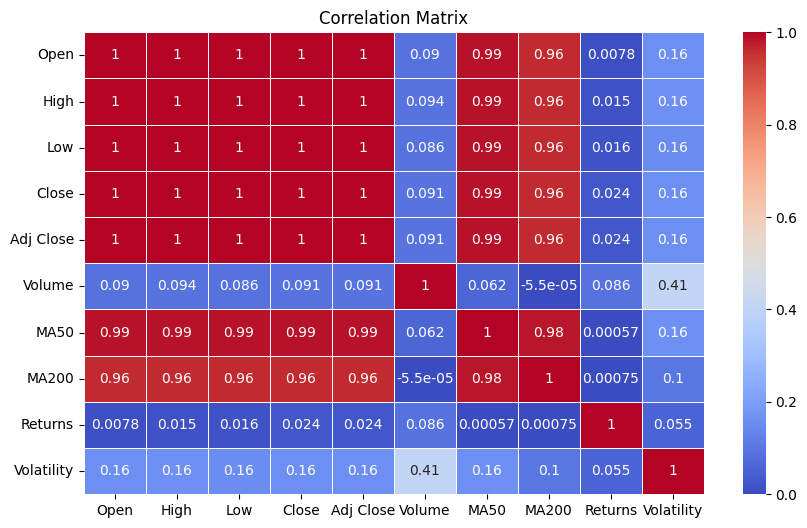

In [6]:

# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [7]:

# Feature selection
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]
target = data['Adj Close']

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, shuffle=False)

# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [8]:

# Model Training: LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(1, X_train.shape[1])))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)
pred_lstm = model_lstm.predict(X_test_lstm).flatten()


2024-08-23 18:43:58.631154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 18:43:58.911724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 18:43:58.911898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 18:43:58.918618: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-23 18:43:58.918799: I external/local_xla/xla/stream_executor

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [9]:

# Improve LSTM Model: Additional Layer and Hyperparameter Tuning
model_lstm_improved = Sequential()
model_lstm_improved.add(LSTM(units=100, return_sequences=True, input_shape=(1, X_train.shape[1])))
model_lstm_improved.add(LSTM(units=50, return_sequences=True))
model_lstm_improved.add(LSTM(units=50))
model_lstm_improved.add(Dense(1))

model_lstm_improved.compile(optimizer='adam', loss='mean_squared_error')
history_lstm_improved = model_lstm_improved.fit(X_train_lstm, y_train, epochs=100, batch_size=16, verbose=0)
pred_lstm_improved = model_lstm_improved.predict(X_test_lstm).flatten()


/home/kumarguptajit/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [10]:

# XGBoost Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))


In [11]:

# Random Forest Model
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))


In [12]:

# Calculate RMSE for Models
rmse_lstm = np.sqrt(mean_squared_error(y_test, pred_lstm))
rmse_lstm_improved = np.sqrt(mean_squared_error(y_test, pred_lstm_improved))


In [13]:

# Print RMSE for each model
print(f'RMSE for LSTM: {rmse_lstm}')
print(f'RMSE for Improved LSTM: {rmse_lstm_improved}')
print(f'RMSE for XGBoost: {rmse_xgb}')
print(f'RMSE for Random Forest: {rmse_rf}')


RMSE for LSTM: 573.7077064168096
RMSE for Improved LSTM: 559.4955176082024
RMSE for XGBoost: 568.709490061067
RMSE for Random Forest: 568.1756920724845


In [14]:

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'LSTM': pred_lstm,
    'Improved LSTM': pred_lstm_improved,
    'XGBoost': pred_xgb,
    'RandomForest': pred_rf
}, index=y_test.index)


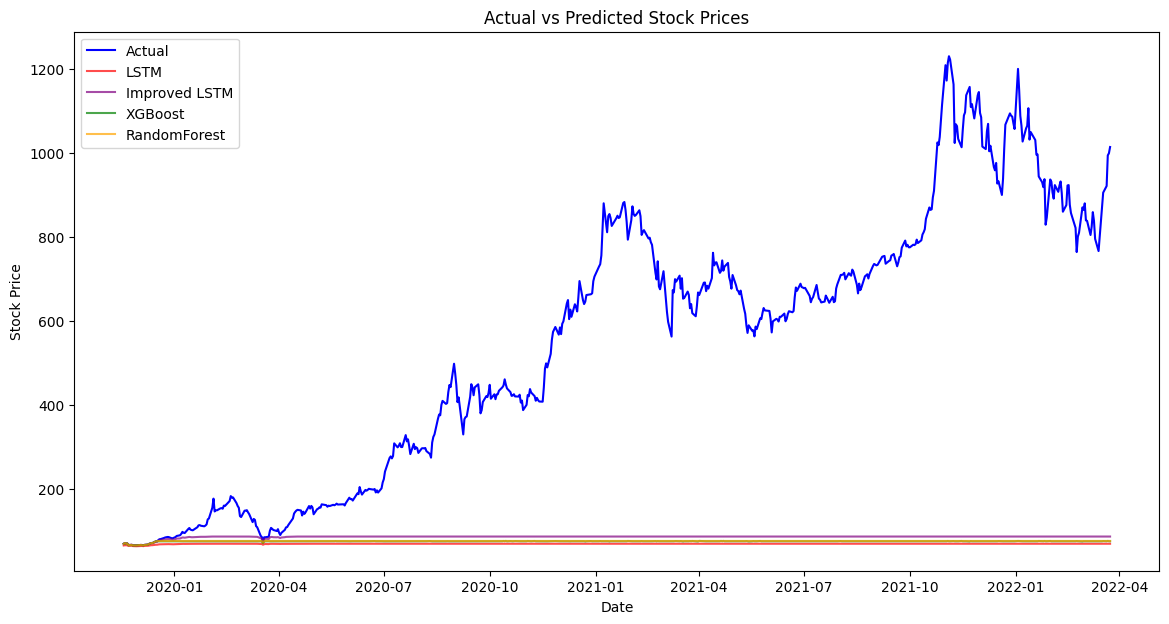

In [15]:

# Plot actual vs predicted stock prices
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
plt.plot(results_df.index, results_df['LSTM'], label='LSTM', color='red', alpha=0.7)
plt.plot(results_df.index, results_df['Improved LSTM'], label='Improved LSTM', color='purple', alpha=0.7)
plt.plot(results_df.index, results_df['XGBoost'], label='XGBoost', color='green', alpha=0.7)
plt.plot(results_df.index, results_df['RandomForest'], label='RandomForest', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


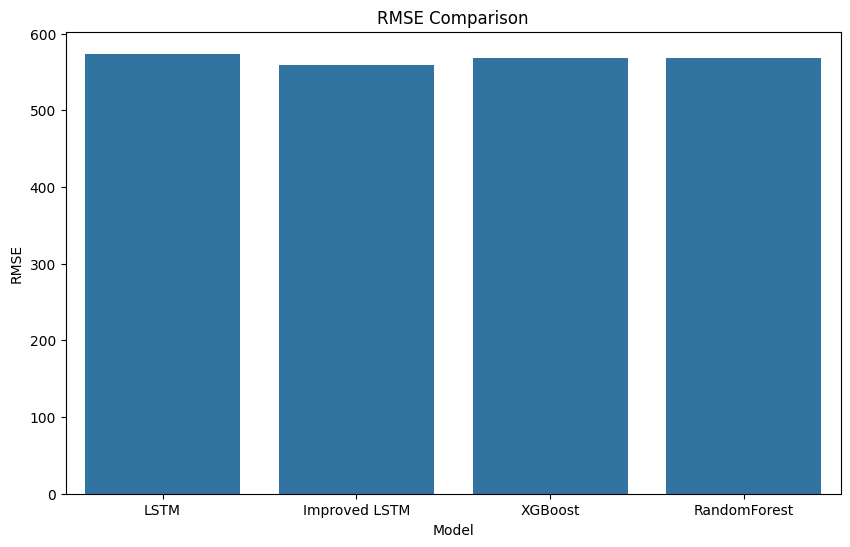

In [16]:

# Plot RMSE comparison
rmse_values = {'Model': ['LSTM', 'Improved LSTM', 'XGBoost', 'RandomForest'], 'RMSE': [rmse_lstm, rmse_lstm_improved, rmse_xgb, rmse_rf]}
rmse_df = pd.DataFrame(rmse_values)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=rmse_df)
plt.title('RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()


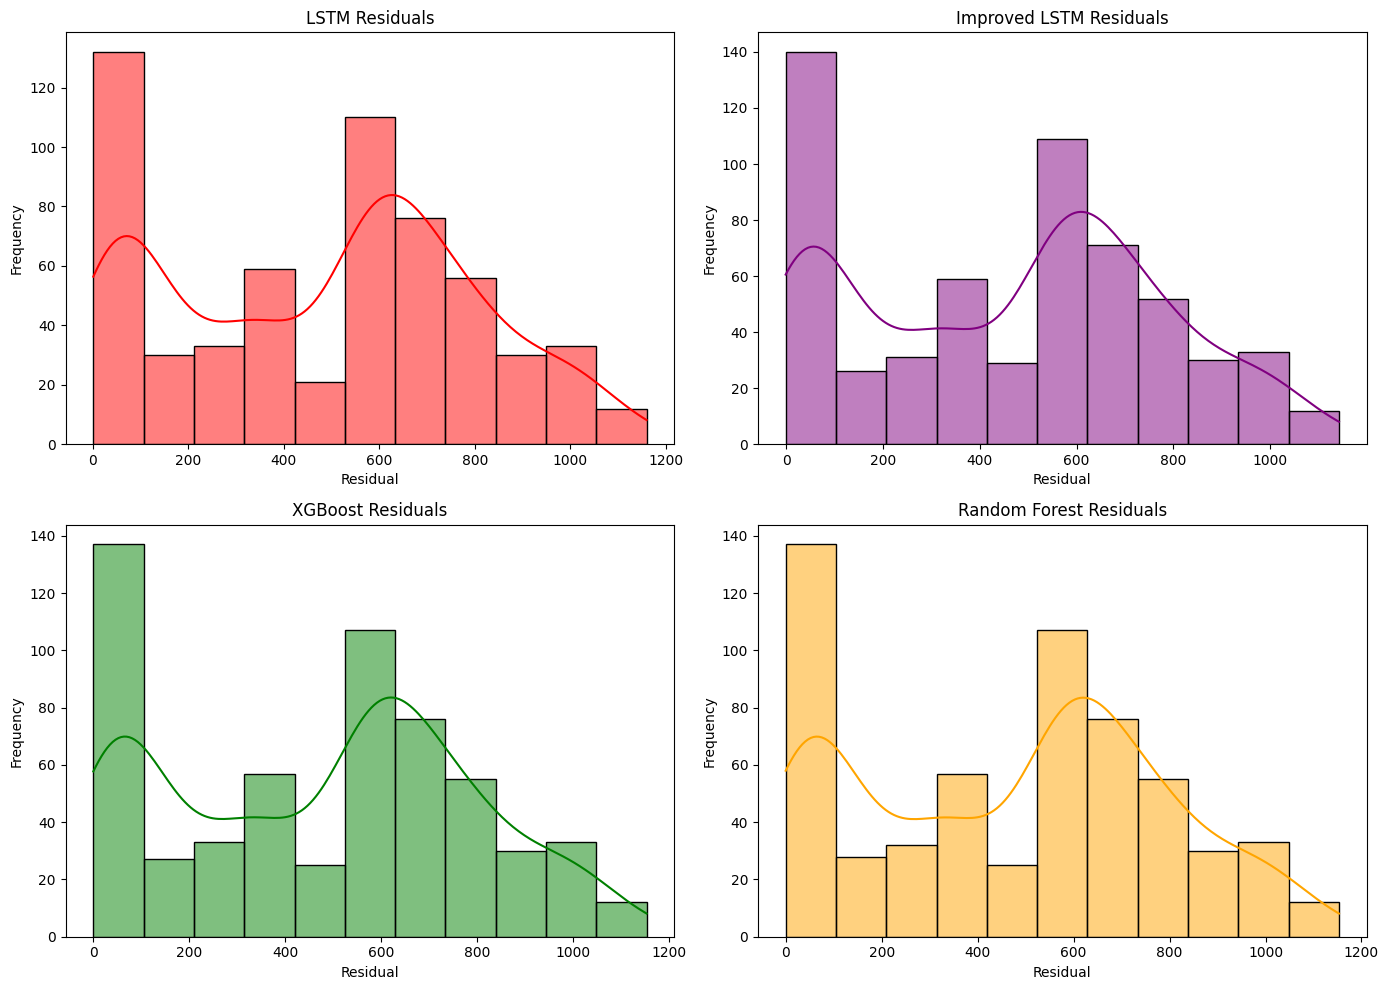

In [24]:
# Model Residuals Distribution (Non-overlapping)
plt.figure(figsize=(14, 10))

# LSTM Residuals
plt.subplot(2, 2, 1)
sns.histplot(y_test - pred_lstm, kde=True, color='red')
plt.title('LSTM Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# Improved LSTM Residuals
plt.subplot(2, 2, 2)
sns.histplot(y_test - pred_lstm_improved, kde=True, color='purple')
plt.title('Improved LSTM Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# XGBoost Residuals
plt.subplot(2, 2, 3)
sns.histplot(y_test - pred_xgb, kde=True, color='green')
plt.title('XGBoost Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# Random Forest Residuals
plt.subplot(2, 2, 4)
sns.histplot(y_test - pred_rf, kde=True, color='orange')
plt.title('Random Forest Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjusts the layout to prevent overlap
plt.show()


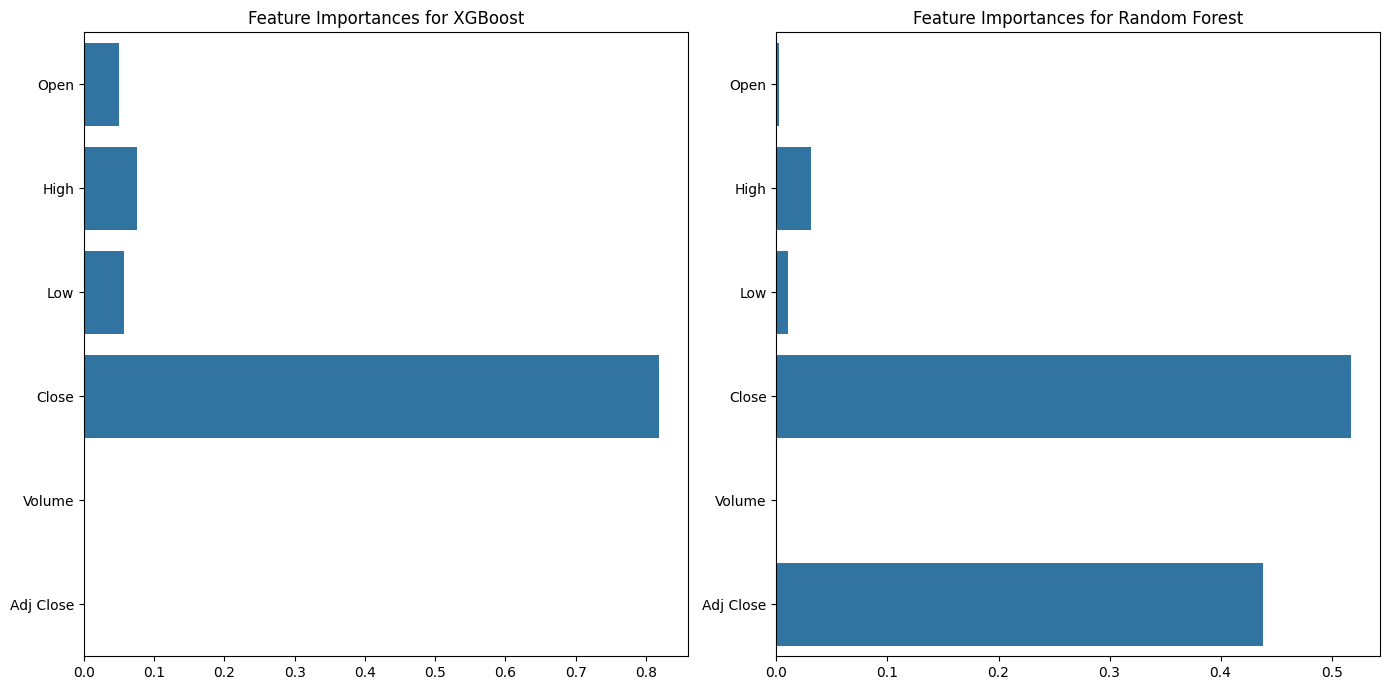

In [31]:

# Feature Importance for XGBoost and RandomForest
xgb_importances = model_xgb.feature_importances_
rf_importances = model_rf.feature_importances_

features_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x=xgb_importances, y=features_names)
plt.title('Feature Importances for XGBoost')

plt.subplot(1, 2, 2)
sns.barplot(x=rf_importances, y=features_names)
plt.title('Feature Importances for Random Forest')

plt.tight_layout()
plt.show()


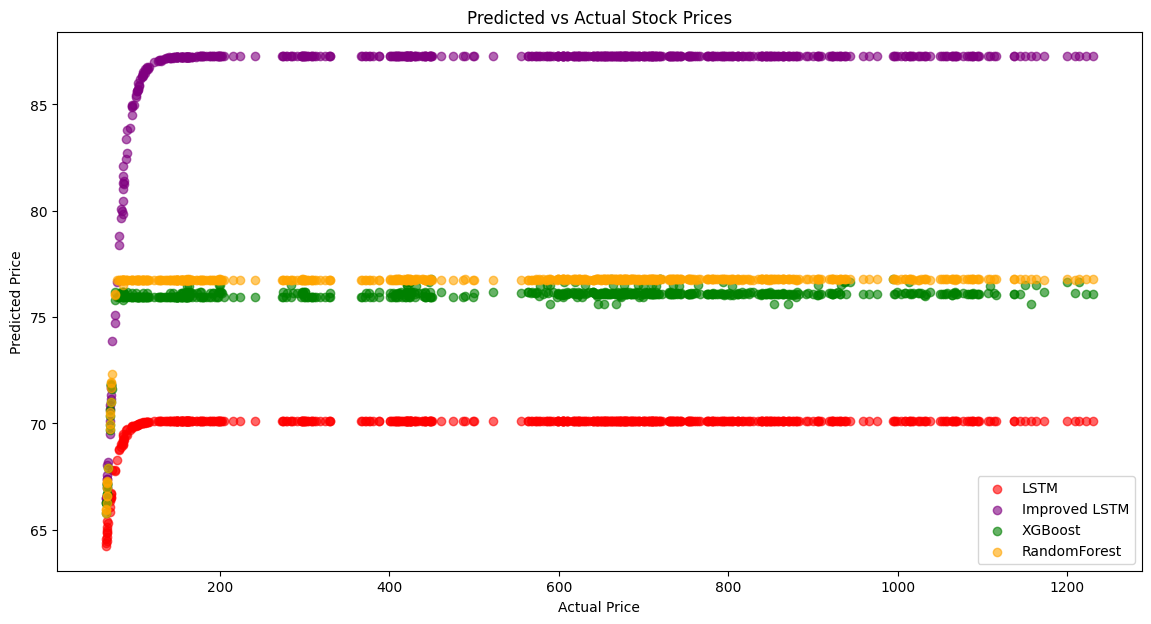

In [32]:

# Prediction vs Actual Scatter Plot
plt.figure(figsize=(14, 7))
plt.scatter(results_df['Actual'], results_df['LSTM'], label='LSTM', color='red', alpha=0.6)
plt.scatter(results_df['Actual'], results_df['Improved LSTM'], label='Improved LSTM', color='purple', alpha=0.6)
plt.scatter(results_df['Actual'], results_df['XGBoost'], label='XGBoost', color='green', alpha=0.6)
plt.scatter(results_df['Actual'], results_df['RandomForest'], label='RandomForest', color='orange', alpha=0.6)
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


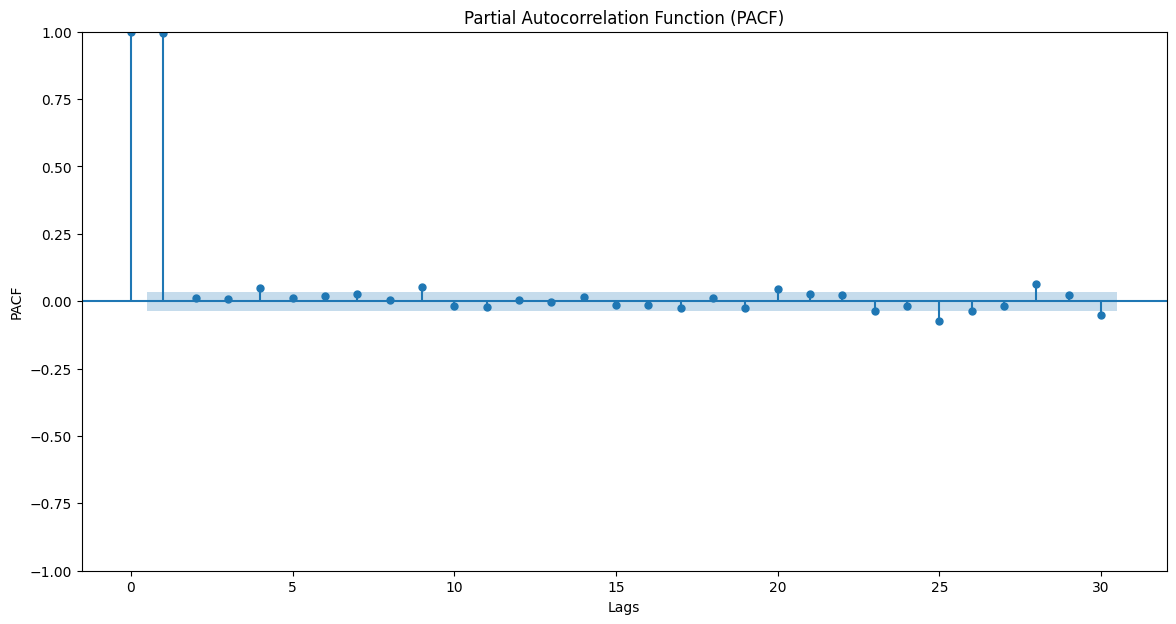

In [33]:

# Partial Autocorrelation Function (PACF)
plt.figure(figsize=(14, 7))
plot_pacf(data['Adj Close'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()



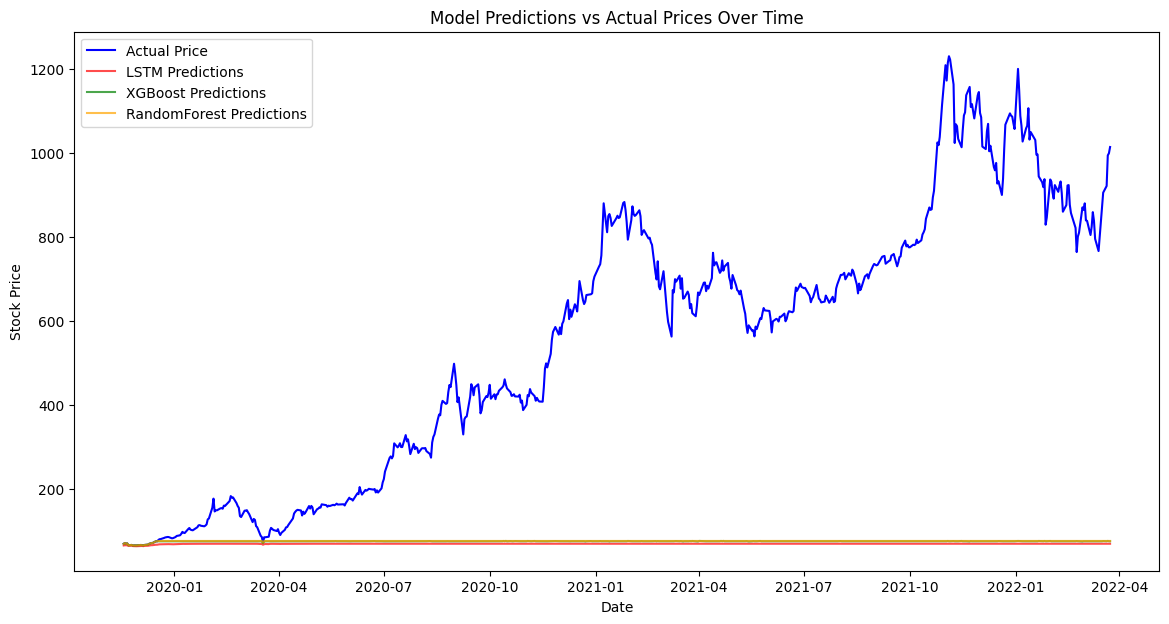

In [34]:
#Predicted vs Actual Values Over Time
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual Price', color='blue')
plt.plot(results_df.index, results_df['LSTM'], label='LSTM Predictions', color='red', alpha=0.7)
plt.plot(results_df.index, results_df['XGBoost'], label='XGBoost Predictions', color='green', alpha=0.7)
plt.plot(results_df.index, results_df['RandomForest'], label='RandomForest Predictions', color='orange', alpha=0.7)
plt.title('Model Predictions vs Actual Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


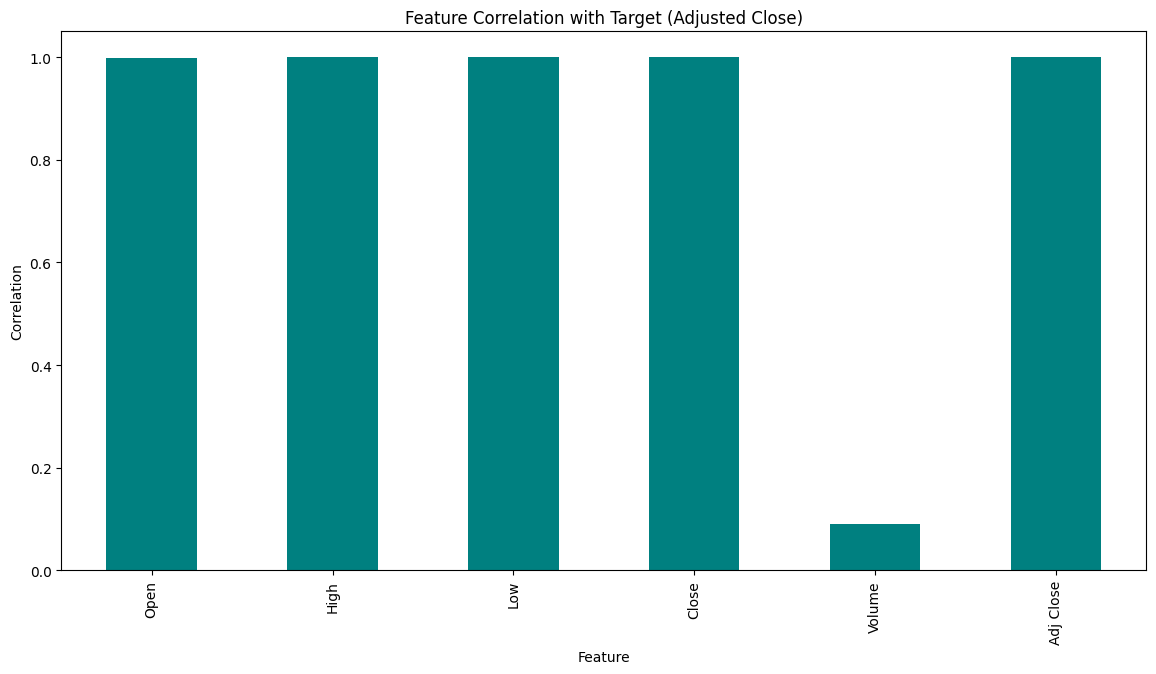

In [35]:
# Feature Correlations with Target
plt.figure(figsize=(14, 7))
correlation = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].corrwith(data['Adj Close'])
correlation.plot(kind='bar', color='teal')
plt.title('Feature Correlation with Target (Adjusted Close)')
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.show()


Distribution of Predictions

/home/kumarguptajit/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


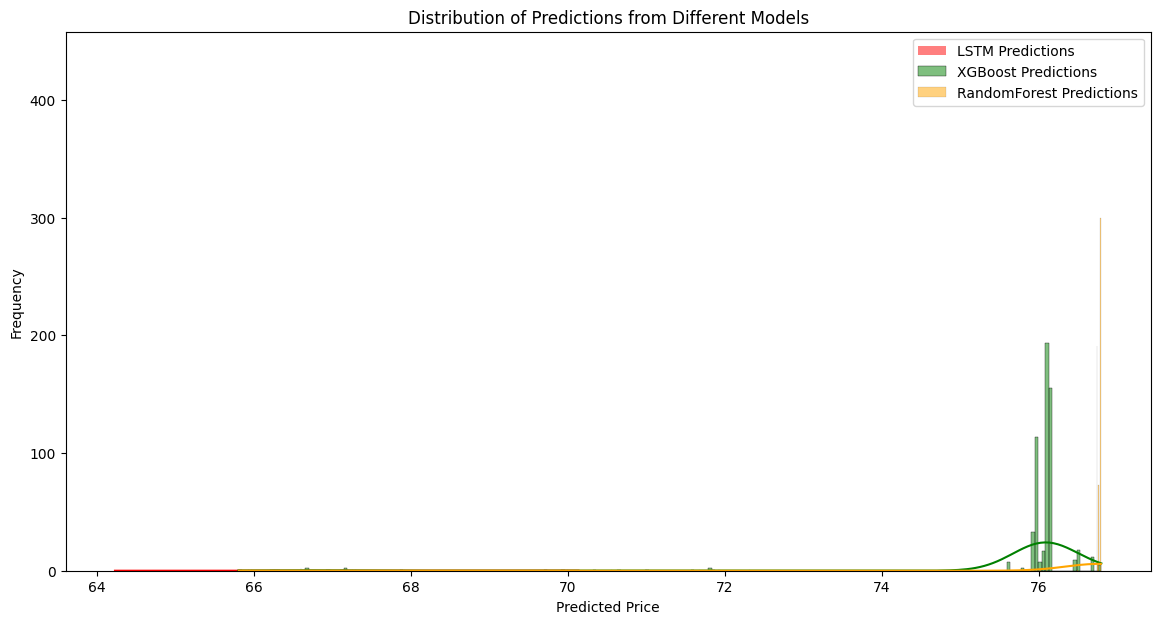

In [36]:
plt.figure(figsize=(14, 7))
sns.histplot(pred_lstm, kde=True, color='red', label='LSTM Predictions', alpha=0.5)
sns.histplot(pred_xgb, kde=True, color='green', label='XGBoost Predictions', alpha=0.5)
sns.histplot(pred_rf, kde=True, color='orange', label='RandomForest Predictions', alpha=0.5)
plt.title('Distribution of Predictions from Different Models')
plt.xlabel('Predicted Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Cumulative Returns Comparison

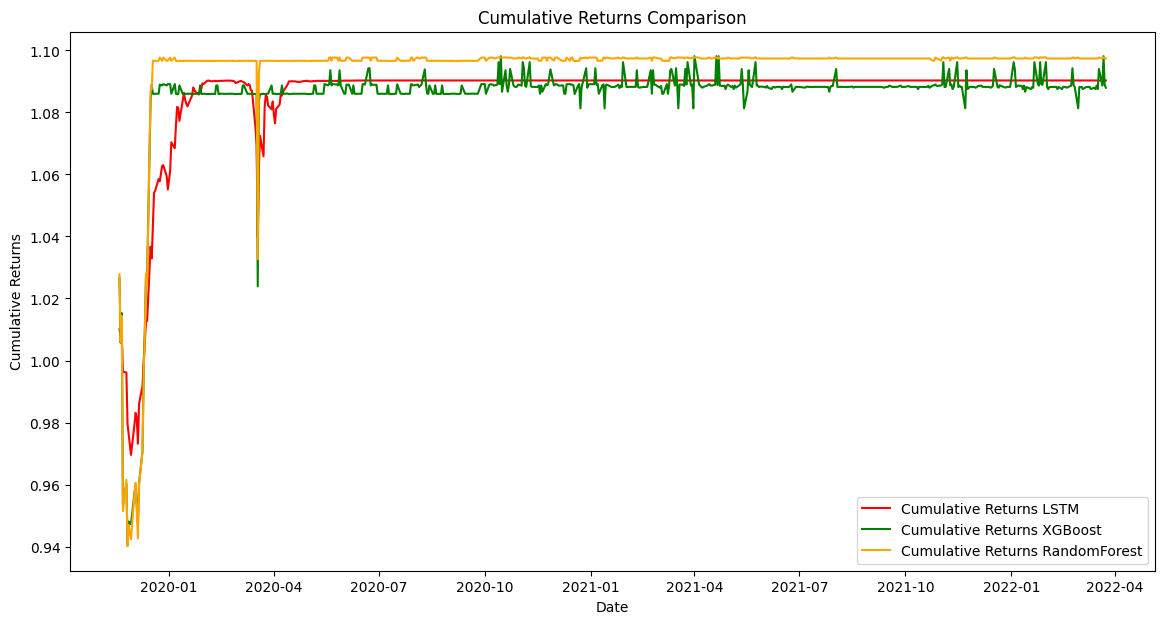

In [ ]:
# Calculate cumulative returns for each model's predictions
results_df['Cumulative LSTM'] = (1 + results_df['LSTM'].pct_change()).cumprod()
results_df['Cumulative XGBoost'] = (1 + results_df['XGBoost'].pct_change()).cumprod()
results_df['Cumulative RandomForest'] = (1 + results_df['RandomForest'].pct_change()).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Cumulative LSTM'], label='Cumulative Returns LSTM', color='red')
plt.plot(results_df.index, results_df['Cumulative XGBoost'], label='Cumulative Returns XGBoost', color='green')
plt.plot(results_df.index, results_df['Cumulative RandomForest'], label='Cumulative Returns RandomForest', color='orange')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


Rolling Statistics for Returns

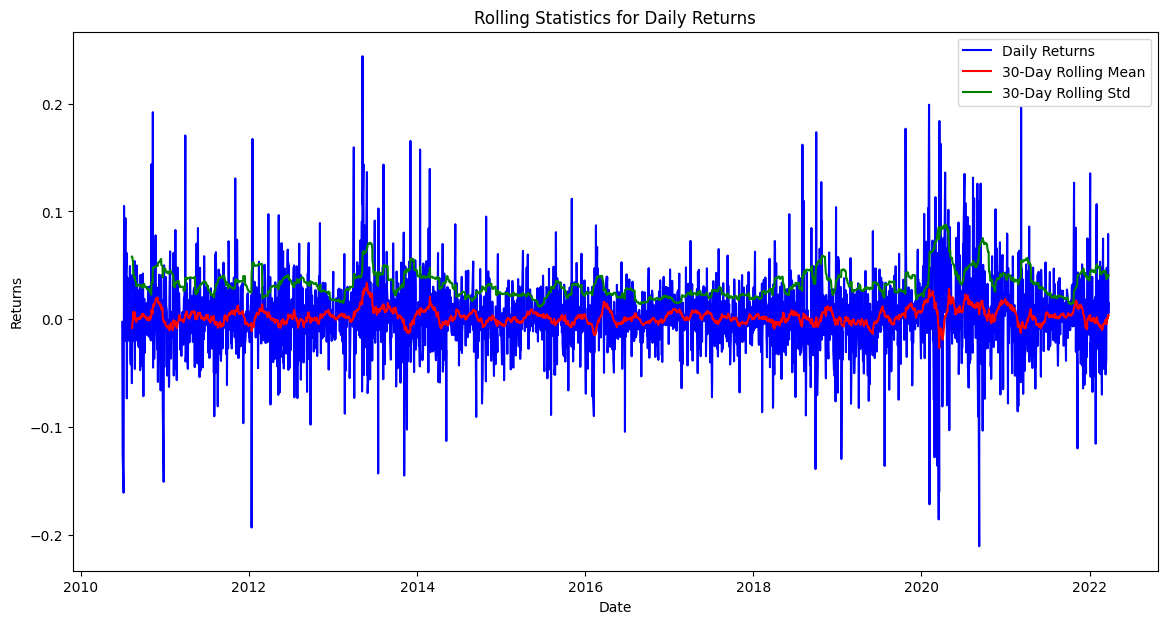

In [ ]:
# Calculate rolling statistics
data['Rolling Mean'] = data['Returns'].rolling(window=30).mean()
data['Rolling Std'] = data['Returns'].rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns'], label='Daily Returns', color='blue')
plt.plot(data.index, data['Rolling Mean'], label='30-Day Rolling Mean', color='red')
plt.plot(data.index, data['Rolling Std'], label='30-Day Rolling Std', color='green')
plt.title('Rolling Statistics for Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()
